In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
#by hand, runs faster
def compute_return(y, r_type="log", h=1):
    
    # exclude first h observations
    y2 = y[h:]
    # exclude last h observations
    y1 = y[:-h]
    
    if r_type == "log":
        ret = np.concatenate(([np.nan]*h, 100 * (np.log(y2) - np.log(y1))))
    else:
        ret = np.concatenate(([np.nan]*h, 100 * (y2-y1)/y1))
        
    return ret

#pythonic alternative (however: slower) to do the same thing:
def compute_return_2(df, r_type="log", h=1):
    
    if r_type == "log":
        return (np.log(df) - np.log(df.shift(h))) * 100
    else:
        return ((df-df.shift(h))/df) * 100 

In [5]:
import yfinance as yf

msft = yf.Ticker("^GDAXI")

In [6]:
hist = msft.history(period="max")

In [7]:
for i in range(5):
    hist["ret"+str(i+1)] = compute_return(hist["Close"].values, h=i+1)

In [8]:
hist.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,ret1,ret2,ret3,ret4,ret5
Date,,,,,,,,,,,,
2023-10-27 00:00:00+02:00,14757.110352,14824.290039,14667.370117,14687.410156,86539200,0.0,0.0,-0.296682,-1.384555,-1.302335,-0.768513,-0.753310
2023-10-30 00:00:00+01:00,14770.950195,14798.000000,14678.730469,14716.540039,76179000,0.0,0.0,0.198136,-0.098546,-1.186419,-1.104199,-0.570378
2023-10-31 00:00:00+01:00,14741.440430,14829.620117,14722.379883,14810.339844,75370200,0.0,0.0,0.635354,0.833490,0.536808,-0.551065,-0.468845
2023-11-01 00:00:00+01:00,14851.959961,14949.580078,14786.320312,14923.269531,63588700,0.0,0.0,0.759613,1.394967,1.593103,1.296421,0.208549
2023-11-02 00:00:00+01:00,15033.650391,15179.320312,15028.030273,15172.929688,0,0.0,0.0,1.659119,2.418732,3.054086,3.252222,2.955540


In [9]:
#quantile levels
tau = [.025, .25, .5, .75, .975]

In [10]:
#define prediction array
#cols are quantile levels, rows are horizons
pred_baseline = np.zeros((5,5))

In [11]:
last_t = 1000

for i in range(5):
    ret_str = "ret"+str(i+1)
    
    pred_baseline[i,:] = np.quantile(hist[ret_str].iloc[-last_t:], q=tau)

Visualize the results

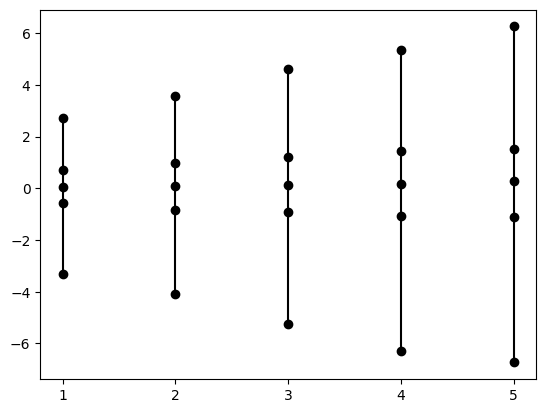

In [12]:
x = np.arange(5)+1
_ = plt.plot(x,pred_baseline, ls="", marker="o", c="black")
_ = plt.xticks(x, x)
_ = plt.plot((x,x),(pred_baseline[:,0], pred_baseline[:,-1]),c='black')

Create Submission DataFrame

In [13]:
df_sub = pd.DataFrame({
    "target": "DAX",
    "horizon": [str(i) + " day" for i in (1,2,5,6,7)],
    "q0.025": pred_baseline[:,0],
    "q0.25": pred_baseline[:,1],
    "q0.5": pred_baseline[:,2],
    "q0.75": pred_baseline[:,3],
    "q0.975": pred_baseline[:,4]})
df_sub

,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975
0,DAX,1 day,-3.321265,-0.552847,0.055432,0.717534,2.719772
1,DAX,2 day,-4.087895,-0.841169,0.077741,0.976061,3.570492
2,DAX,5 day,-5.259161,-0.926504,0.135565,1.194919,4.628697
3,DAX,6 day,-6.282629,-1.055648,0.178666,1.426987,5.367396
4,DAX,7 day,-6.735742,-1.094754,0.300695,1.518241,6.259934


In [14]:
from datetime import datetime
date_str = datetime.today().strftime('%Y%m%d')

In [16]:
#need to change this
PATH = "./"

df_sub.to_csv(PATH+"/"+date_str+"DAX_benchmark.csv")